Importing Packages And Basic Set up

In [15]:
#.venv/scripts/activate  ; no source. 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import numpy as np
import pandas as pd

Importing Datasets

In [16]:
# Importing maindata
file_path = "C://Users/miste/Documents/Causal_ML/"
x = pd.read_stata(file_path + "maindata.dta", convert_categoricals=False)

# Importing laws_csv, cleaning it
laws_csv = pd.read_csv(file_path + "When_Were_Laws.csv")
laws_csv = laws_csv[np.logical_not(np.isnan(laws_csv["FIPS"]))]  # FIPS codes identify states
laws_csv = laws_csv.drop("State_Name", axis=1)  # Dropping as useless
laws_csv = laws_csv.rename({'FIPS': 'stfips'}, axis=1) 

# Merging
merged = pd.merge(laws_csv, x, on='stfips', how='outer')

Cleaning Datasets, only interested in the 1997 states. 

In [17]:
basic_merged = merged.copy()  # To allow for re-running 

basic_merged = basic_merged[basic_merged["a_age"] <= 25]  # Can be changed later, but for now useful I think

# Dropping states who were treated < 97 (i.e. they always had programs)
basic_merged = basic_merged[basic_merged["Year_Implemented"].str.contains("always")==False]  

# Making it so that "never-treated" states are treated at T = infinity
basic_merged = basic_merged.replace("never", "1000000") 
basic_merged["Year_Implemented"] = basic_merged["Year_Implemented"].astype(int)  # converting to int


# indicator for if treatment has occured in state i
basic_merged["year_indic"] = (basic_merged["year"] >= basic_merged["Year_Implemented"]) 


# Indicator for if the individual was treated (i.e. under 19 and in a state who added a law)
basic_merged["treatment"] = basic_merged["under19"] * basic_merged["year_indic"]


# Generating list of confounders of interest, these are not necessarily optimal. 
list_of_confounders = ["year", "stfips", "fownu18", "faminctm1", "a_maritl", "female" , "fpovcut", "povll"]
list_of_confounders += ["anykids", "disability", "noemp_insured"]

# Subsetting our dataset to only include the columns we want
basic_merged = basic_merged[list_of_confounders + ["under19", "treatment", "pubonly", "insured", "privonly", "Year_Implemented"]]

Fitting Q

$\underline{\bold{\text{Estimating causal effect}}}$

Subsetting data

In [18]:
# Picking an arbitrary state which implemented in 1997
state_level = basic_merged[basic_merged["stfips"] == 9]

top_year = 1997  # Year the policy was introduced 
base_year = 1996  # Year prior to that


# Drop missings
state_level = state_level.dropna(axis = 0)
state_level["year"] = state_level["year"] - base_year # Normalizing for interpretability. 


# Setting up matrices with confounders and the treatment
confounders_and_treat = state_level[list_of_confounders + ["treatment"]]
confounders_and_treat = confounders_and_treat.drop("stfips", axis=1)


# Matrix which also includes indicator for age
con_and_treat_and_under = state_level[list_of_confounders + ["treatment", "under19"]]
con_and_treat_and_under = con_and_treat_and_under.drop("stfips", axis=1)


# Outcome of interest, this can be set to: ["pubonly", "insured", "privonly"]
y_var = state_level["insured"]

Fitting Model

In [19]:
# This is probably where my model goes wrong, as we're likely overfitting. Keep stratified k-fold

x_train, x_test, y_train, y_test = train_test_split(confounders_and_treat, y_var, test_size=0.2)

Q = RandomForestClassifier(max_depth=5, n_estimators=100)
Q.fit(x_train, y_train) # Didn't do splitting, can do later. 
print(Q.score(x_test, y_test))

0.8034965034965035


Estimating the ATT's


In [20]:
mean_list = []  # Will end up being a list of the average ATT's
CI_list = []  # Will end up being a list of the confidence intervals 
for i in range(1992, 2009):  # We compute the ATT for each year
    top_year = i - 1996  # Normalizing for interpretability (t = 1 is when treatment occurs)

    # This part is from the paper, it says we should use 1996 (t = 0) as the year to compare against for
    # any year >= 1997

    # For any year prior to treatment, it says we should compare that year (t = t') to the prior year (t = t' - 1)
    if top_year >= 1:
        base_year = 0  # This is 
    else:
        base_year = top_year - 1

    # Copying the matrix which contains: confounders (con), treatment (treat) and the indicator for under19 (under)
    treat_1 = con_and_treat_and_under.copy()

    # Subsetting to only look at the units which appear in t = 1 (1997)
    treat_1 = treat_1[treat_1["year"] == top_year]
    treat_1 = treat_1[treat_1["under19"] == 1]  # Only looking at treated units (i.e. <19)
    treat_1 = treat_1.drop("under19", axis=1)  # We no longer need this
    treat_1["treatment"] = 1  # This is because we may have "treatment = 0" if year < 1997, but we want to pretend it is 
                              # treated to estimate the ATT there. Essentially we're pretending that treatment did occur
                              # then, and ideally we would see ATT ~ 0 there. 

    # The same matrix but we pretend they were untreated
    no_treat_1 = treat_1.copy()
    no_treat_1["treatment"] = 0

    # Now we repeat this, but we pretend those units appear in 1996 (t = 0)
    # This is because we need to have a set of covariates to look at, and I think it makes a little more
    # sense to look at the people who were actually treated, rather than those who "would have been."
    treat_0 = treat_1.copy()
    no_treat_0 = no_treat_1.copy()

    treat_0["year"] = base_year
    no_treat_0["year"] = base_year

    # Predicting our outcomes, and doing the normal DiD 
    term_1 = Q.predict_proba(treat_1)[:,1]
    term_2 = Q.predict_proba(treat_0)[:,1]
    term_3 = Q.predict_proba(no_treat_1)[:,1]
    term_4 = Q.predict_proba(no_treat_0)[:,1]

    final = term_1 - term_2 - (term_3 - term_4)
    mean_list += [np.mean(final) * 100] 
    CI_list += [np.std(final) / np.sqrt(treat_1.shape[0]) * 100 * 1.96] # the ".shape" part is just to get the right n

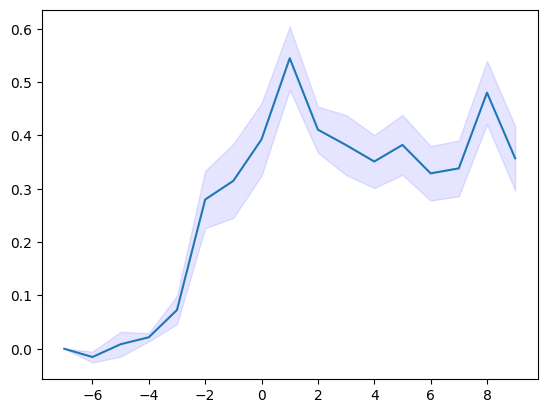

In [21]:
# Plotting

x = np.arange(-7, 10, 1)

plt.plot(x, mean_list)
# Computing the actual CI's -- the thing before was just the radius. 
subtracted = [element1 - element2 for (element1, element2) in zip(mean_list, CI_list)]
added = [element1 + element2 for (element1, element2) in zip(mean_list, CI_list)]

# Adding in the CI's
plt.fill_between(x, (subtracted), (added), color='blue', alpha=0.1)
plt.show() 